建物データと浸水面標高ラスターデータから建物の被災データを生成。（必要手続き：Driveの接続）

3_CalcFloodDEMRaster.ipynbの実行後は再起動させる必要があります。

In [ ]:
# @title Googleドライブの準備
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title 日本の調査IDと自治体コードから住所情報を得る
survey_id = "A002005212020" #@param {type: "string"}
pref_code = "40" #@param
city_code = "203" #@param

In [ ]:
# @title 設定するパラメータ

# ケース名：解析を通して使います。
casename = "kurume-r2-rev2"

maxdepth = 4.27

local_government_code = f"{pref_code}{city_code}"


In [ ]:
# @title 詳細設定用パラメータ（基本的には操作不要）

enable_savefig = False # 図をGoogleドライブに保存する？

zoomlevel = 15 # DEM zoom level to fetch

# デバッグ用出力
global globalflag_debug

# 保存先
path_home = "/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/"
path_cgml = path_home + "/CityGML/"
path_dem = path_home + "/DEM/"
path_case = path_home + casename + "/"
path_upload = path_case + "ForUpload/"
json_buildings = path_case+"buildings_parsed.json"
json_boundary = path_case +"boundary.json"
file_bbox = path_case + "boundbox.npy"
file_dem_fmt = path_case + "dem_{}_{}-{}_{}-{}.npz"

file_flooddem = path_case + "flood_dem_{:04d}.npz"
file_flooddepth = path_case + "flood_depth_{:04d}.npz"

file_building_csv = path_upload + "flood_buildings.csv"

In [ ]:
# @title shapeファイルをダウンロードする．
%cd {path_home}
!mkdir shapes
%cd shapes

import requests
import re
from urllib.parse import unquote

# ダウンロードするファイルのURL
local_government_code = f"{pref_code}{city_code}"
url = f"https://www.e-stat.go.jp/gis/statmap-search/data?dlserveyId={survey_id}&code={local_government_code}&coordSys=1&format=shape&downloadType=5&datum=2000"

def get_filename_from_cd(cd):
    """
    Content-Dispositionヘッダーからファイル名を取得する関数
    """
    if not cd:
        return None
    fname = re.findall("filename\*=UTF-8''(.+)", cd)
    if len(fname) == 0:
        return None
    return unquote(fname[0])

# ファイルをダウンロードし保存する関数
def download_file(url):
    """
    指定されたURLからファイルをダウンロードし、Content-Dispositionヘッダーから取得したファイル名で保存する
    """
    with requests.get(url, stream=True) as response:
        response.raise_for_status()
        filename = get_filename_from_cd(response.headers.get('content-disposition'))
        if not filename:
            filename = 'downloaded_file.zip'
        with open(filename, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192): 
                file.write(chunk)
        print(f"ファイルがダウンロードされました: {filename}")
    return filename

# ファイルのダウンロード
shp_filename = download_file(url)

import os
shape_dir = os.path.splitext(shp_filename)[0]
!mkdir {shape_dir}
!unzip -o {shp_filename} -d {shape_dir}

%cd {path_home}
from glob import glob

address_shp = glob(f"shapes/{shape_dir}/*.shp")[0] # このコードの場所からみた住所のshpファイルの相対パス
shape_file = path_home + address_shp

In [ ]:
# @title 主要ライブラリインポート
import json
import matplotlib.pyplot as plt
import numpy as np
from progressbar import progressbar
from shapely.geometry import MultiPolygon, shape, mapping, Point
!pip install rasterio
import rasterio
from rasterio.features import geometry_mask
import fiona
import csv
import sys
sys.path.append(path_home)
import plateau_floodsar_lib as pfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 61.4 MB/s eta 0:00:00


In [ ]:
# JSONファイルからデータを読み込む
with open(json_buildings, 'r') as f:
    buildings = json.load(f)

print(len(buildings))

93812


In [ ]:
print(buildings[0:10])
print(len([vv for vv in buildings if vv["measured_height"] <2.1]))

[{'gid': 'bldg_3cb0e9f7-b41b-4878-913b-46d1e2dedf1a', 'center': [130.41604077609813, 33.229505114004475], 'min_height': 3.9700000286102295, 'measured_height': 9.2, 'building_structure_type': '木造・土蔵造', 'dem': 4.125166070767237}, {'gid': 'bldg_363395aa-b8d9-44a1-ac50-9caa50b5e732', 'center': [130.41939122469583, 33.22906997523014], 'min_height': 4.116000175476074, 'measured_height': 8.4, 'building_structure_type': '木造・土蔵造', 'dem': 4.335711880961094}, {'gid': 'bldg_4a9afd94-8acb-48ec-b9bc-b1ed51af93cd', 'center': [130.42021406825302, 33.232273024912956], 'min_height': 4.197000026702881, 'measured_height': 6.3, 'building_structure_type': '非木造', 'dem': 4.288519125482499}, {'gid': 'bldg_b3437b17-95a1-4332-84c9-17e33812f67e', 'center': [130.4249566389965, 33.231985121837276], 'min_height': 4.181000232696533, 'measured_height': 5.5, 'building_structure_type': '木造・土蔵造', 'dem': 4.414278952189304}, {'gid': 'bldg_c7f80779-078d-40ec-a55b-14b848f5990b', 'center': [130.41683692013206, 33.227068674114

In [ ]:
building_types = set([vv["building_structure_type"] for vv in buildings])
print(building_types)

{'不明', '非木造', '鉄筋コンクリート造', '木造・土蔵造', None}


In [ ]:
#depth_map = np.load(file_flooddepth.format(int(maxdepth*100)))
dem_map = np.load(file_flooddem.format(int(maxdepth*100)))

In [ ]:
#lons = depth_map["lons"]
#lats = depth_map["lats"]
#depthmap = depth_map["floodmap_depth"]
lons = dem_map["lons"]
lats = dem_map["lats"]
demmap = dem_map["floodmap_dem"]

In [ ]:
#np.set_printoptions(threshold=np.inf)
print(lons)
print(lats)

[130.39672852 130.39677143 130.39681435 ... 130.70421696 130.70425987
 130.70430279]
[33.36718262 33.36714675 33.36711088 ... 33.22036074 33.22032487
 33.220289  ]


In [ ]:
print(demmap)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


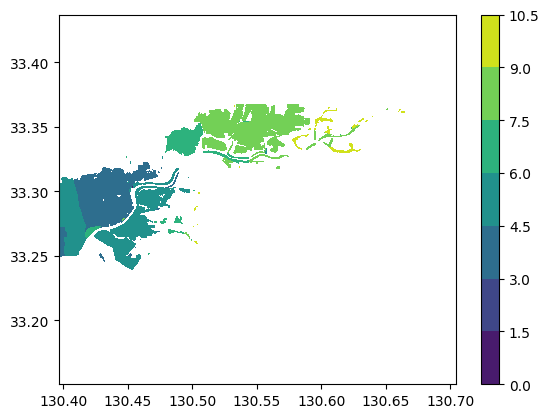

In [ ]:
ax =plt.subplot(1,1,1)
#img = ax.contourf(lons,lats, depthmap,levels=np.arange(0,maxdepth+0.1,0.25))
img = ax.contourf(lons,lats, demmap)#,levels=np.arange(0,maxdepth+0.1,0.25))
ax.axis("equal")
plt.colorbar(img)
#ax.set_xlim(130.4,130.5)
#ax.set_ylim(33.22,33.32)

In [ ]:
bldgtype_yukaue_depth = {"木造・土蔵造":0.45, "レンガ造・コンクリートブロック造・石造":0.45, "不明":0.45}
bldgtype_mokuzou = ["木造・土蔵造"]
bldgtype_block = [""]
def get_floodcategory(bldg_type, depth):
  min_depth = bldgtype_yukaue_depth[bldg_type] if bldg_type in bldgtype_yukaue_depth else 0.0
  category = "非浸水"
  if depth is not None and depth >0:
    if depth > min_depth :
      if min_depth == 0:
        category = "浸水"
      else:
        category = "床上"
    elif depth > 0:
      category = "床下"
    if bldg_type in bldgtype_mokuzou:
      category += "（木造）"
    elif bldg_type == "不明" or bldg_type is None:
      category += "（不明）"
    else:
      category += "（非木造）"
  return category

In [ ]:
print(get_floodcategory("木造・土蔵造", 1) )
print(get_floodcategory("木造・土蔵造", 0.2) )
print(get_floodcategory("不明", 1) )
print(get_floodcategory("不明", 0.3) )
print(get_floodcategory("非木造", 1) )
print(get_floodcategory(None, -1) )
print(get_floodcategory(None, None) )

床上（木造）
床下（木造）
床上（不明）
床下（不明）
浸水（非木造）
非浸水
非浸水


In [ ]:
def calc_floatIdx_of_list(val:float, list):
  """
  Args:
      val (float): value which the method finds index for.
      list (array-like): must be ordered (ascending or descending)
  """
  try:
    if list[0] < list[-1]:
      idl = np.where(val > list)[0][-1]
    else:
      idl = np.where(val < list)[0][-1]
  except IndexError:
    print("IndexErrorCheck:", val, (list[0], list[-1]))
    return np.nan
  if idl == len(list) -1:
    return idl
  return idl + (val-list[idl])/(list[idl+1]-list[idl])
  #return (val - list[0])/(list[-1]-list[0]) * (len(list)-1)

def calc_interpval_of_list(idx:float, list):
  il = int(idx)
  ih = int(idx + 1)
  if ih >= len(list):
    return list[-1]
  dd = idx - il
  return (1-dd)*list[il] + dd*list[ih]

def calc_InterpVal_lonlat(lon, lat, data, lons, lats):
  #print("Check1: ", lon, lat)
  cx = calc_floatIdx_of_list(lon, lons)
  cy = calc_floatIdx_of_list(lat, lats)
  #print("Check: ", cx, cy, "\n")
  if np.any(np.isnan([cy, cx])):
    return np.nan
  xl = int(cx)
  yl = int(cy)
  xh = xl + 1
  dx = cx-xl
  yh = yl + 1
  dy = cy - yl
  if xh > len(lons)-1:
    xh = xl
  if yh > len(lats)-1:
    yh = yl
  val_ll = data[yl,xl]
  val_hl = data[yh,xl]
  val_lh = data[yl,xh]
  val_hh = data[yh, xh]
  return (1-dy)*(1-dx)*val_ll + (1-dy)*dx*val_lh + dy*(1-dx)*val_hl + dy*dx*val_hh

In [ ]:
print(lons[0], lons[-1])
print(lats[0], lats[-1])

130.396728515625 130.70430278778076
33.36718262246804 33.22028899788433


In [ ]:
#@title 住所付与の準備

# shpファイルのパス

# マルチポリゴンのバウンディングボックスを取得します。
minx, miny, maxx, maxy = lons.min(), lats.min(), lons.max(), lats.max() # [130.412497, 33.224723, 130.68759971, 33.40869805]
# ラスタライズのパラメータを設定します。
raster_height, raster_width = demmap.shape # (5376, 6656)

transform = rasterio.transform.from_origin(minx, maxy, (maxx-minx)/raster_width, (maxy-miny)/raster_height)

lookup_table = []

# shpファイルを開く
with fiona.open(shape_file, 'r') as src:
    with rasterio.MemoryFile() as memfile:
        with memfile.open(driver='GTiff',
                          height=raster_height,
                          width=raster_width,
                          count=1,
                          dtype='uint8',
                          crs=src.crs,
                          transform=transform) as dataset:
            combined_mask = np.empty((dataset.height, dataset.width))
            combined_mask[:] = np.nan
            for i, feature in enumerate(src):
                # 各フィーチャからジオメトリを取得し、shapelyオブジェクトに変換
                polygon = shape(feature['geometry'])
                mask = geometry_mask([mapping(polygon)],
                                      transform=dataset.transform,
                                      invert=True,
                                      out_shape=(dataset.height, dataset.width))
                combined_mask[mask] = i
                del mask

                # PREF_NAME 福岡県
                # CITY_NAME 久留米市
                # S_NAME 花畑三丁目
                pref_name = feature["properties"]["PREF_NAME"]
                city_name = feature["properties"]["CITY_NAME"]
                s_name = feature["properties"]["S_NAME"]
                lookup_table.append({
                    "id": i,
                    "address": s_name,
                    "vector": polygon
                })


#plt.imshow(combined_mask)

new_lons = np.linspace(lons.min(), lons.max(), raster_width)  # 経度
new_lats = np.linspace(lats.max(), lats.min(), raster_height)   # 緯度

def get_address_ids(lon, lat, combined_mask):
    #center_lon, center_lat = building['center']

    # 緯度経度からピクセル座標に変換
    #lons_to_pixel = np.searchsorted(lons, center_lon) - 1
    #lats_to_pixel = np.searchsorted(lats, center_lat) - 1
    lons_to_pixel = int(calc_floatIdx_of_list(lon, new_lons))
    lats_to_pixel = int(calc_floatIdx_of_list(lat, new_lats))

    # # 周囲のセルを調べるための正規分布を作成
    # x, y = np.meshgrid(np.arange(combined_mask.shape[1]), np.arange(combined_mask.shape[0]))
    # pos = np.dstack((x, y))
    # rv = multivariate_normal([lons_to_pixel, lats_to_pixel], [[1.22, 0], [0, 1.22]])
    # gaussian_mask = rv.pdf(pos)

    # # 正規分布からしきい値を超えるセルのIDを取得
    # # threshold = gaussian_mask.mean()
    # # ids = combined_mask[gaussian_mask > threshold]

    ids = combined_mask[lats_to_pixel-1:lats_to_pixel+2, lons_to_pixel-1:lons_to_pixel+2] # 中心と周囲8ピクセルを見る
    unique_ids = np.unique(ids[~np.isnan(ids)])  # np.nanを除外してユニークなIDを取得

    return unique_ids

def find_address(lon, lat, combined_mask):
      address_ids = get_address_ids(lon, lat, combined_mask)
      address = ""
      if len(address_ids) == 0:
          address = '不明'
      elif len(address_ids) == 1:
          address = lookup_table[int(address_ids[0])]['address']
      else:
          # 複数のIDがある場合の処理
          # lookup_tableのベクトルと照合して正しいIDを見つける処理
          center_point =  Point(lon, lat) # Point(building['center'][0], building['center'][1])
          possible_addresses = []

          for address_id in address_ids:
              for entry in lookup_table:
                  if entry['id'] == address_id:
                      polygon = shape(entry['vector'])
                      if polygon.contains(center_point):
                          possible_addresses.append(entry['address'])
                          break  # 最初にマッチしたアドレスでループを抜ける

          if possible_addresses:
              address = possible_addresses[0]  # 最初に見つかった住所を採用
          else:
              # どのポリゴンにも含まれなかったら周囲の住所を全て列挙
              address = " / ".join([entry['address'] for entry in lookup_table if entry['id'] in address_ids])
      return address

# 処理を実行
#buildings_with_address = assign_address(buildings, combined_mask)

In [ ]:
for bb in progressbar(buildings):
  lon, lat = bb["center"]
  #print(lon, lat)
  #depth = calc_InterpVal_lonlat(lon, lat, depthmap, lons, lats)
  dem = calc_InterpVal_lonlat(lon, lat, demmap, lons, lats)
  depth = dem - bb["min_height"] #  bb["dem"]
  bb["lon"] = bb["center"][0]
  bb["lat"] = bb["center"][1]
  #print(depth)
  if np.isnan(depth):
    bb["out"] = True
    bb["flood_category"] = "非浸水"
    bb["depth"] = None
  else:
    bb["out"] = False
    bb["flood_category"] = get_floodcategory(bb["building_structure_type"], depth)
    bb["depth"] = depth
    if bb["flood_category"] == "非浸水":
      bb["out"] = True
  bb["address"] = find_address(lon,lat,combined_mask)

100% (93812 of 93812) |##################| Elapsed Time: 0:00:14 Time:  0:00:14


In [ ]:
print("2.1m未満：", len([bb for bb in buildings if bb["measured_height"] < 2.1]))

2.1m未満： 0


In [ ]:
num_flooded = len([bb for bb in buildings if not bb["out"]])
num_yukashita = len([bb for bb in buildings if "床下" in bb["flood_category"]])

print(num_flooded,"(",num_yukashita,")/",len(buildings))

2676 ( 1127 )/ 93812


<function matplotlib.pyplot.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs)>

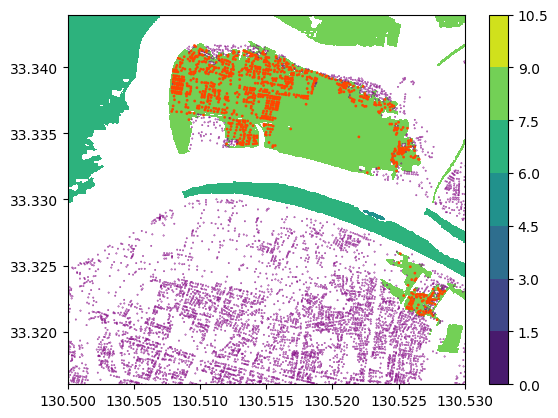

In [ ]:
xx = [bb["center"][0] for bb in buildings]
yy = [bb["center"][1] for bb in buildings]
cc = ["orangered" if not bb["out"] else "purple" for bb in buildings]
ss = [1 if not bb["out"] else 0.1 for bb in buildings]
aa = [1 if not bb["out"] else 0.01 for bb in buildings]
ax =plt.subplot(1,1,1)
#img = ax.contourf(lons,lats, depthmap,levels=np.arange(0,maxdepth+0.1,0.25))
img = ax.contourf(lons,lats, demmap)#,levels=np.arange(0,maxdepth+0.1,0.25))
plt.scatter(xx,yy,c=cc,s=ss)#, alpha=aa)
ax.axis("equal")
plt.xlim([130.50, 130.53])
plt.ylim([33.32, 33.34])
plt.colorbar(img)
plt.scatter

In [ ]:
!mkdir {path_upload}
csv_keylist = ['gid', 'lon', 'lat', 'min_height', 'flood_category','depth', 'address']
csv_header = ['gid', 'lon', 'lat', 'dem', 'flood_category','flood_depth', 'address']
with open(file_building_csv, "w") as ofile:
  ofile.write(",".join(f"'{w}'" for w in csv_header)+"\n")
  for bb in buildings:
    tempstr = ""
    for kk in csv_keylist:
      if isinstance(bb[kk], str):
        tempstr += f"'{bb[kk]}',"
      else:
        tempstr += f"{bb[kk]},"
    ofile.write(tempstr[:-1]+"\n")
    #print(tempstr[:-1])
